# Imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import os
import warnings
import scipy.stats as stats
from scipy.fftpack import fft

# Load stuff

In [2]:
base_path = '/Users/priyank/Desktop/ML4QS-project/Clapping_right_5mins'

In [3]:
folders = [
    'Clapping_2_minutes',
    'Clapping_3_minutes'
]

In [4]:
file_names = ['Accelerometer.csv', 'Gyroscope.csv', 'Linear Accelerometer.csv', 'Magnetometer.csv']
sensor_types = ['accelerometer', 'gyroscope', 'linear_accelerometer', 'magnetometer']

# Function to construct file paths
def construct_file_paths(base_path, folders, file_names):
    file_paths = {}
    for sensor_type, file_name in zip(sensor_types, file_names):
        file_paths[sensor_type] = [os.path.join(base_path, folder, file_name) for folder in folders]
    return file_paths

file_paths = construct_file_paths(base_path, folders, file_names)

# Function to load data files and add labels
def load_and_label_data(file_paths, label):
    dfs = []
    for file in file_paths:
        df = pd.read_csv(file)
        # Add a label column
        df['label'] = label
        dfs.append(df)
    return dfs

# Load and label data for each sensor type
label = 'waving_righthand'
data_dict = {}
for sensor_type in sensor_types:
    data_dict[sensor_type] = load_and_label_data(file_paths[sensor_type], label)

# Aggregate Data at 0.25s intervals

In [5]:
# Function to create time intervals
def create_time_intervals(start_time, end_time, delta_t):
    return np.arange(start_time, end_time, delta_t)

# Function to aggregate data within time steps
def aggregate_data(df, time_column, delta_t, numerical_columns, label):
    start_time = df[time_column].min()
    end_time = df[time_column].max()
    time_intervals = create_time_intervals(start_time, end_time, delta_t)
    
    aggregated_data = []

    for t in time_intervals:
        window = df[(df[time_column] >= t) & (df[time_column] < t + delta_t)]
        if not window.empty:
            aggregated_row = {}
            aggregated_row['time'] = t
            for col in numerical_columns:
                aggregated_row[col] = window[col].mean()
            # Add the label to the aggregated row
            aggregated_row['label'] = label
            aggregated_data.append(aggregated_row)

    return pd.DataFrame(aggregated_data)

# Define time step and columns
delta_t = 0.25  # 0.25 seconds

# Specify numerical columns for each sensor type
numerical_columns_dict = {
    'accelerometer': ['X (m/s^2)', 'Y (m/s^2)', 'Z (m/s^2)'],
    'gyroscope': ['X (rad/s)', 'Y (rad/s)', 'Z (rad/s)'],
    'linear_accelerometer': ['X (m/s^2)', 'Y (m/s^2)', 'Z (m/s^2)'],
    'magnetometer': ['X (µT)', 'Y (µT)', 'Z (µT)']
}

# Aggregate data for each sensor type in each folder
aggregated_data_dict = {sensor_type: [] for sensor_type in sensor_types}

for sensor_type in sensor_types:
    for df in data_dict[sensor_type]:
        aggregated_df = aggregate_data(df, 'Time (s)', delta_t, numerical_columns_dict[sensor_type], label)
        aggregated_data_dict[sensor_type].append(aggregated_df)


## Save the data 

In [6]:
# Function to save aggregated data back into respective folders with modified filenames
def save_aggregated_data(base_path, folders, file_names, aggregated_data_dict, interval_label="0.25s"):
    for sensor_type, file_name in zip(sensor_types, file_names):
        for folder, df in zip(folders, aggregated_data_dict[sensor_type]):
            new_file_name = file_name.replace('.csv', f'_{interval_label}.csv')
            output_path = os.path.join(base_path, folder, new_file_name)
            df.to_csv(output_path, index=False)
            print(f"Saved aggregated data to {output_path}")

save_aggregated_data(base_path, folders, file_names, aggregated_data_dict)


Saved aggregated data to /Users/priyank/Desktop/ML4QS-project/Clapping_right_5mins/Clapping_2_minutes/Accelerometer_0.25s.csv
Saved aggregated data to /Users/priyank/Desktop/ML4QS-project/Clapping_right_5mins/Clapping_3_minutes/Accelerometer_0.25s.csv
Saved aggregated data to /Users/priyank/Desktop/ML4QS-project/Clapping_right_5mins/Clapping_2_minutes/Gyroscope_0.25s.csv
Saved aggregated data to /Users/priyank/Desktop/ML4QS-project/Clapping_right_5mins/Clapping_3_minutes/Gyroscope_0.25s.csv
Saved aggregated data to /Users/priyank/Desktop/ML4QS-project/Clapping_right_5mins/Clapping_2_minutes/Linear Accelerometer_0.25s.csv
Saved aggregated data to /Users/priyank/Desktop/ML4QS-project/Clapping_right_5mins/Clapping_3_minutes/Linear Accelerometer_0.25s.csv
Saved aggregated data to /Users/priyank/Desktop/ML4QS-project/Clapping_right_5mins/Clapping_2_minutes/Magnetometer_0.25s.csv
Saved aggregated data to /Users/priyank/Desktop/ML4QS-project/Clapping_right_5mins/Clapping_3_minutes/Magnetomete

# EDA

In [7]:
file_names = ['Accelerometer_0.25s.csv', 'Gyroscope_0.25s.csv', 'Linear Accelerometer_0.25s.csv', 'Magnetometer_0.25s.csv']
sensor_types = ['accelerometer', 'gyroscope', 'linear_accelerometer', 'magnetometer']

# Function to construct file paths
def construct_file_paths(base_path, folders, file_names):
    file_paths = {}
    for sensor_type, file_name in zip(sensor_types, file_names):
        file_paths[sensor_type] = [os.path.join(base_path, folder, file_name) for folder in folders]
    return file_paths

file_paths = construct_file_paths(base_path, folders, file_names)

# Function to load aggregated data files
def load_aggregated_data(file_paths):
    dfs = {}
    for sensor_type in sensor_types:
        dfs[sensor_type] = [pd.read_csv(file) for file in file_paths[sensor_type]]
    return dfs

# Load aggregated data
aggregated_data_dict = load_aggregated_data(file_paths)

## Summary stats

In [8]:
# Display summary statistics for numerical columns
for sensor_type in sensor_types:
    print(f"Summary Statistics for {sensor_type}:")
    for df in aggregated_data_dict[sensor_type]:
        print(df.describe())


Summary Statistics for accelerometer:
             time   X (m/s^2)   Y (m/s^2)   Z (m/s^2)
count  481.000000  481.000000  481.000000  481.000000
mean    59.999693    3.972800    8.462625    0.154176
std     34.749251    1.262321    0.805134    2.604226
min     -0.000307    0.490997    6.230661   -6.606973
25%     29.999693    3.087126    7.924293   -1.864445
50%     59.999693    3.671751    8.511271    0.205109
75%     89.999693    4.861746    9.090830    1.917087
max    119.999693    7.685963   10.011912    8.333572
             time   X (m/s^2)   Y (m/s^2)   Z (m/s^2)
count  721.000000  721.000000  721.000000  721.000000
mean    90.002648    3.000530    7.405558   -0.198969
std     52.069765    1.799475    1.784246    6.031742
min      0.002648   -2.641407   -1.183930  -18.353783
25%     45.002648    1.518867    6.675213   -4.363133
50%     90.002648    3.123189    7.837402    0.208061
75%    135.002648    4.441627    8.561722    4.195463
max    180.002648    7.814931   12.196188   

## Missing Vals

In [9]:
# Check for missing values in the dataset
for sensor_type in sensor_types:
    print(f"Missing Values for {sensor_type}:")
    for df in aggregated_data_dict[sensor_type]:
        print(df.isnull().sum())


Missing Values for accelerometer:
time         0
X (m/s^2)    0
Y (m/s^2)    0
Z (m/s^2)    0
label        0
dtype: int64
time         0
X (m/s^2)    0
Y (m/s^2)    0
Z (m/s^2)    0
label        0
dtype: int64
Missing Values for gyroscope:
time         0
X (rad/s)    0
Y (rad/s)    0
Z (rad/s)    0
label        0
dtype: int64
time         0
X (rad/s)    0
Y (rad/s)    0
Z (rad/s)    0
label        0
dtype: int64
Missing Values for linear_accelerometer:
time         0
X (m/s^2)    0
Y (m/s^2)    0
Z (m/s^2)    0
label        0
dtype: int64
time         0
X (m/s^2)    0
Y (m/s^2)    0
Z (m/s^2)    0
label        0
dtype: int64
Missing Values for magnetometer:
time      0
X (µT)    0
Y (µT)    0
Z (µT)    0
label     0
dtype: int64
time      0
X (µT)    0
Y (µT)    0
Z (µT)    0
label     0
dtype: int64


## Correlation Matrix

Correlation Matrix for accelerometer:


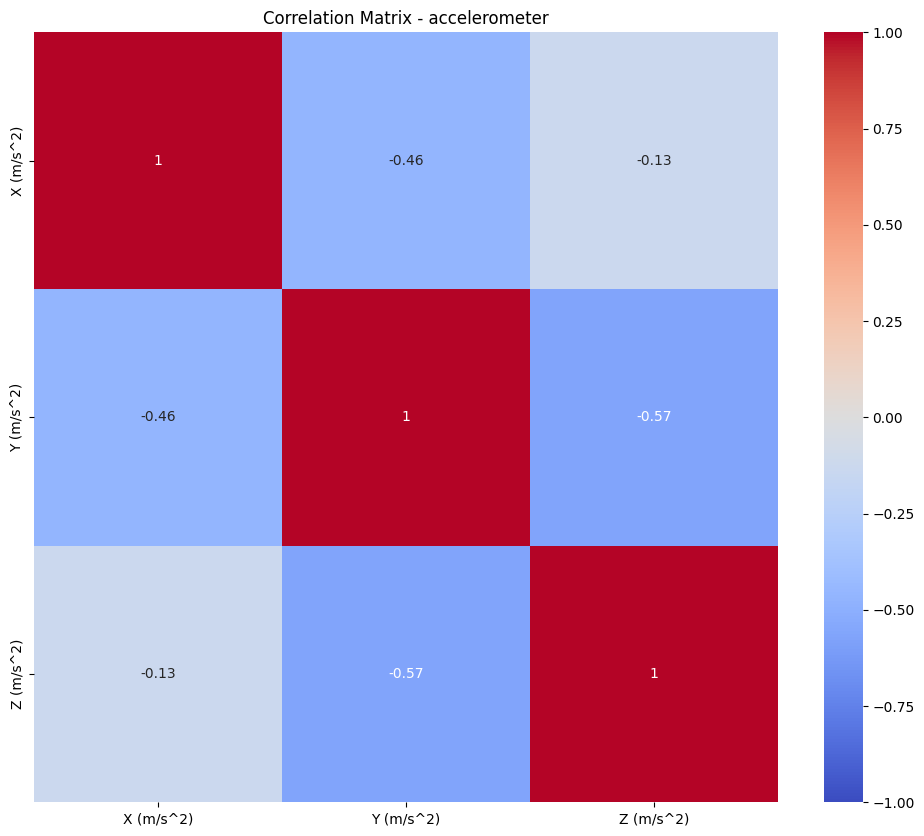

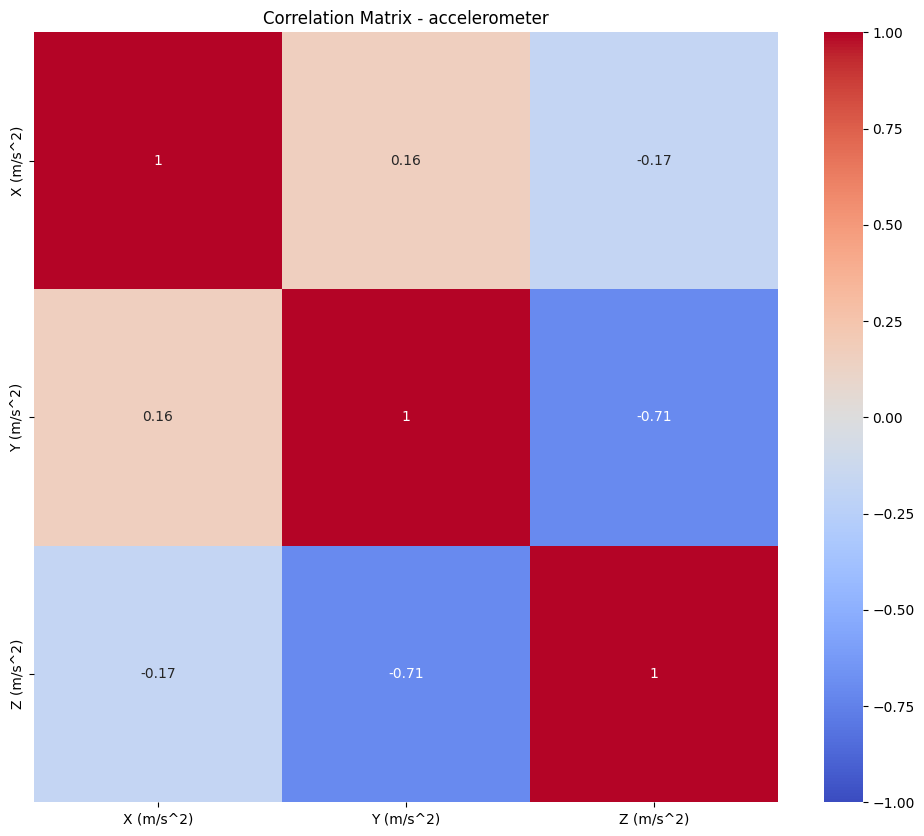

Correlation Matrix for gyroscope:


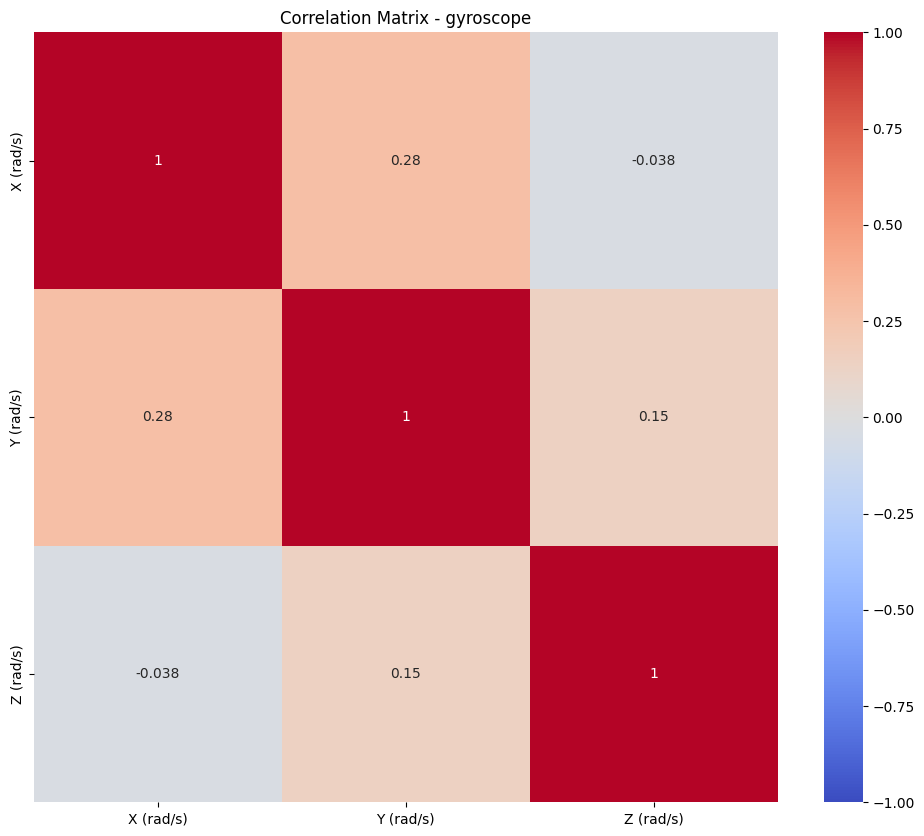

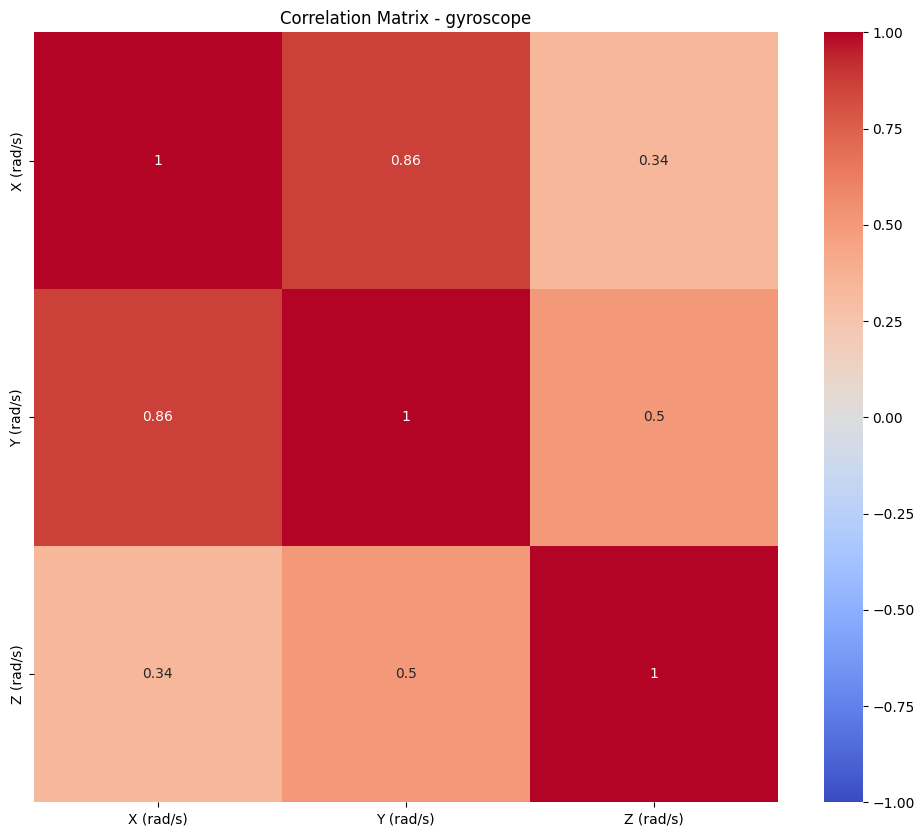

Correlation Matrix for linear_accelerometer:


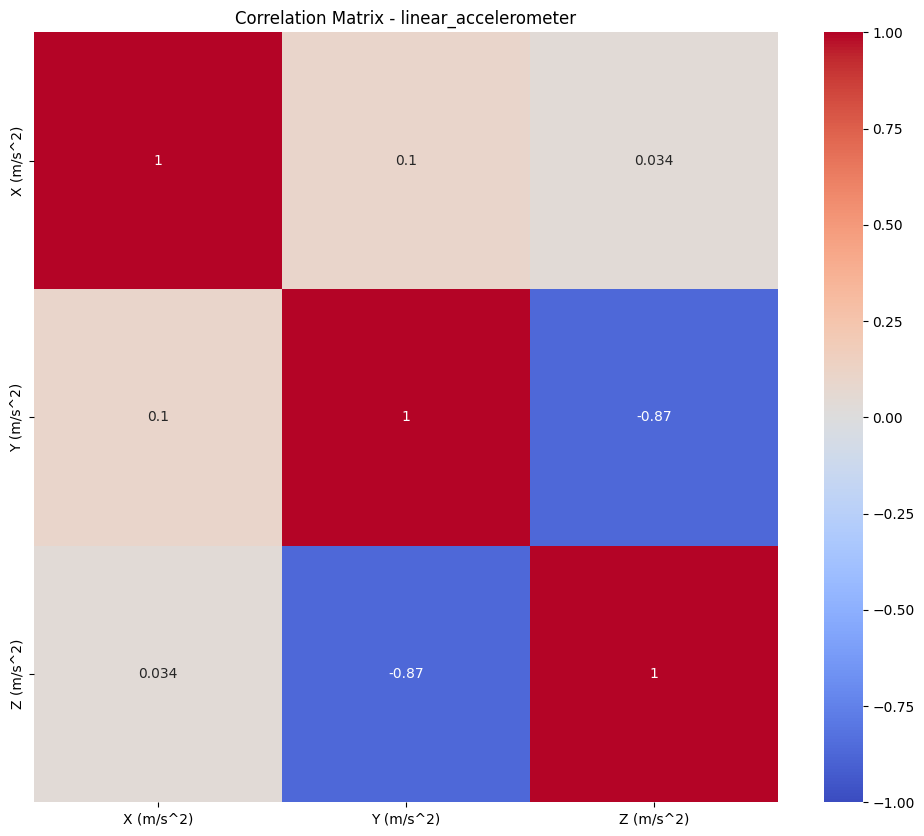

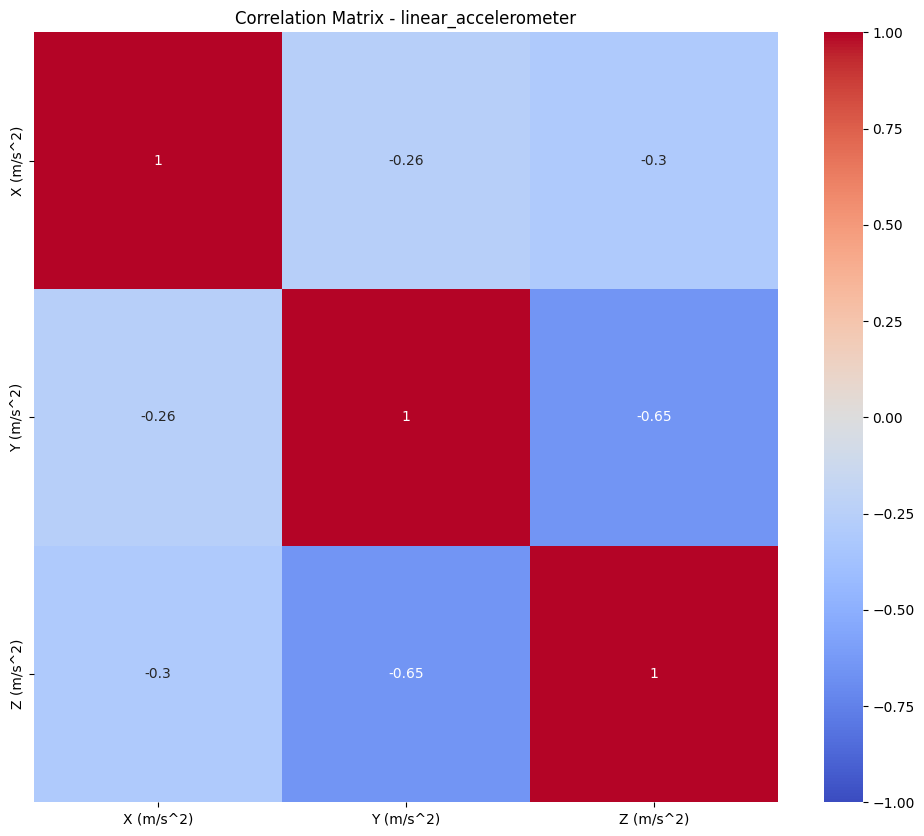

Correlation Matrix for magnetometer:


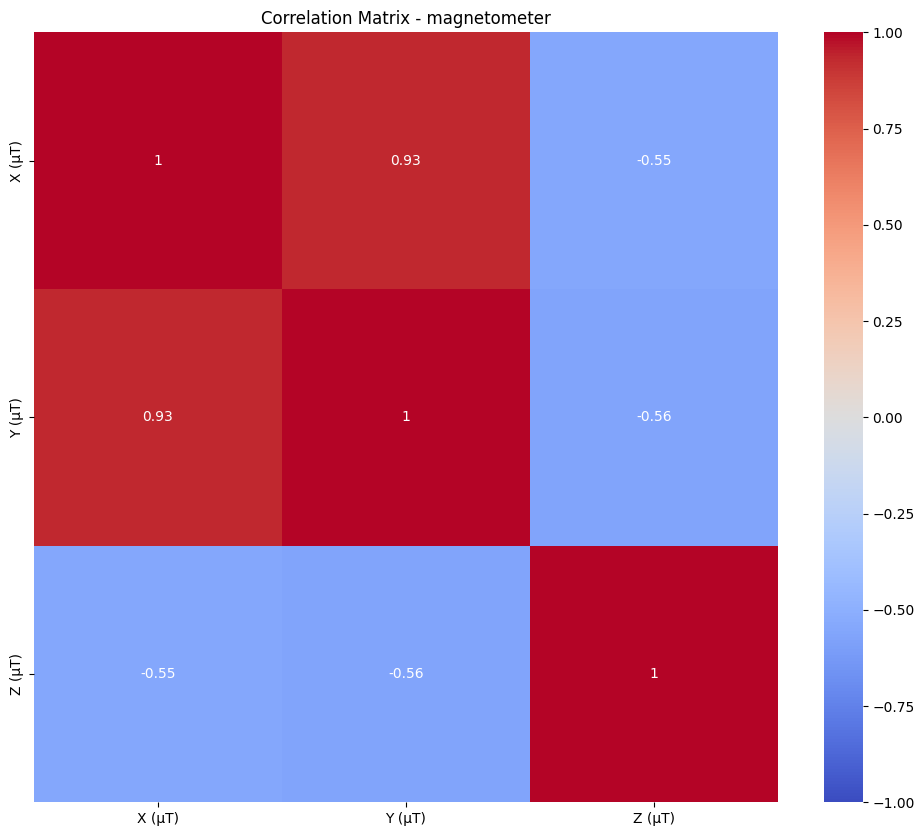

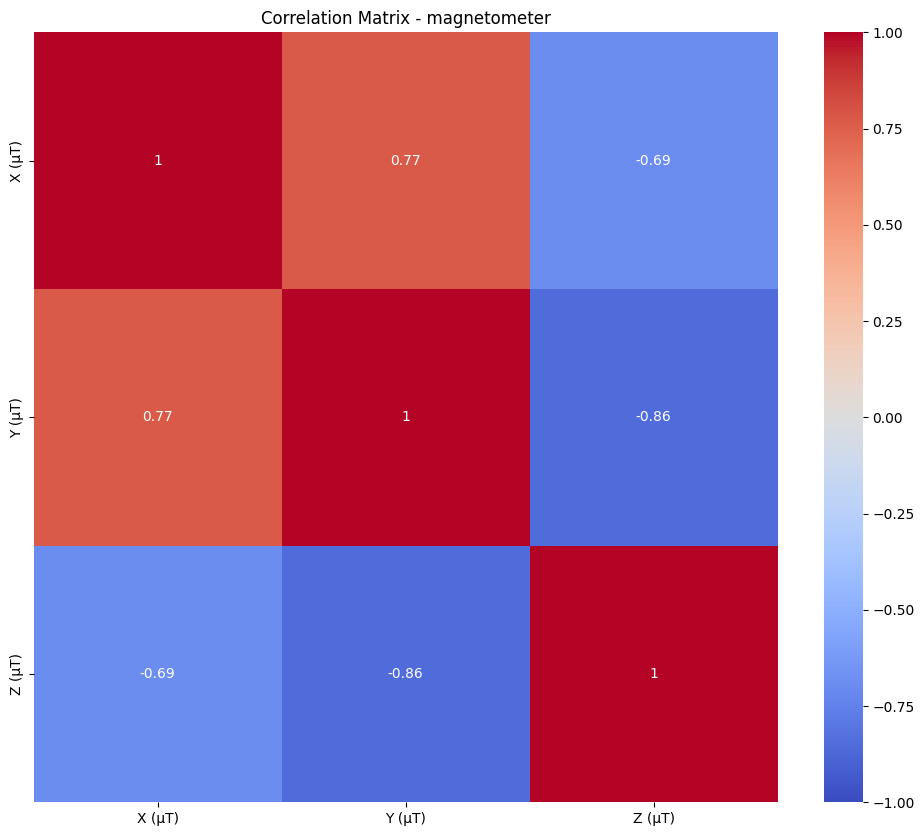

In [10]:

# Compute and visualize the correlation matrix for numerical features
for sensor_type in sensor_types:
    print(f"Correlation Matrix for {sensor_type}:")
    for df in aggregated_data_dict[sensor_type]:
        numerical_cols = [col for col in df.columns if col not in ['time', 'label']]
        corr_matrix = df[numerical_cols].corr()

        plt.figure(figsize=(12, 10))
        sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
        plt.title(f'Correlation Matrix - {sensor_type}')
        plt.show()


Histograms for accelerometer:


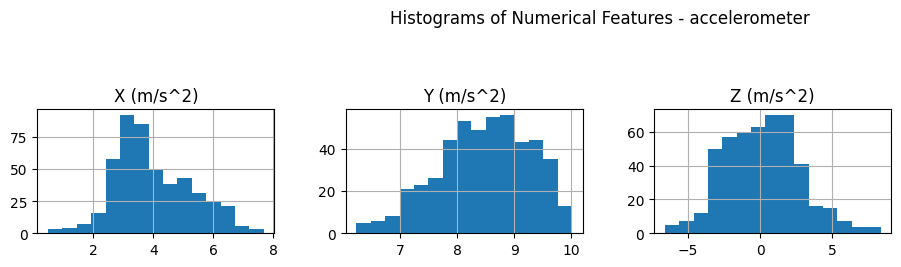

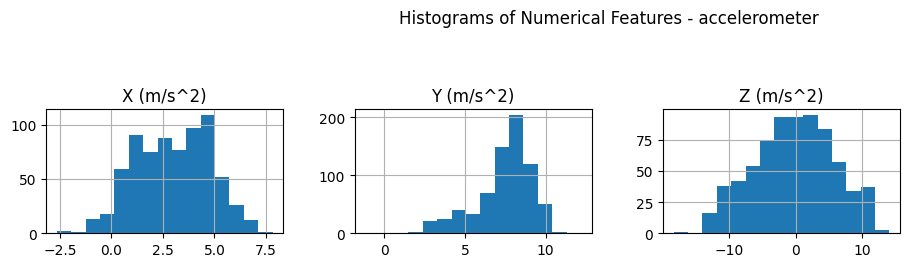

Histograms for gyroscope:


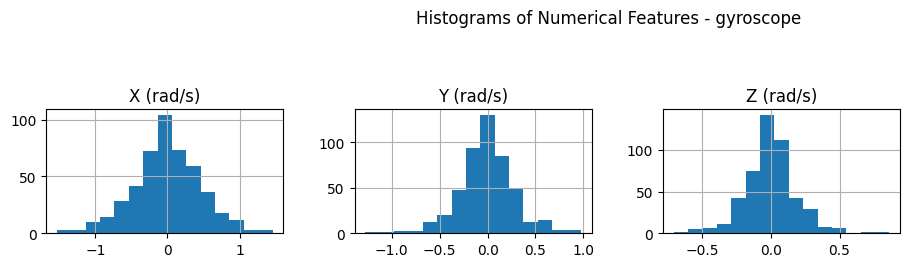

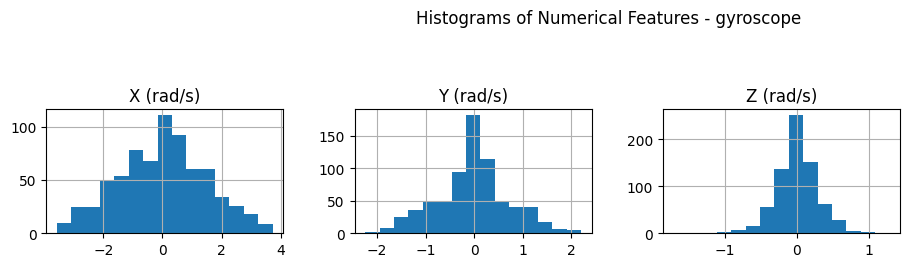

Histograms for linear_accelerometer:


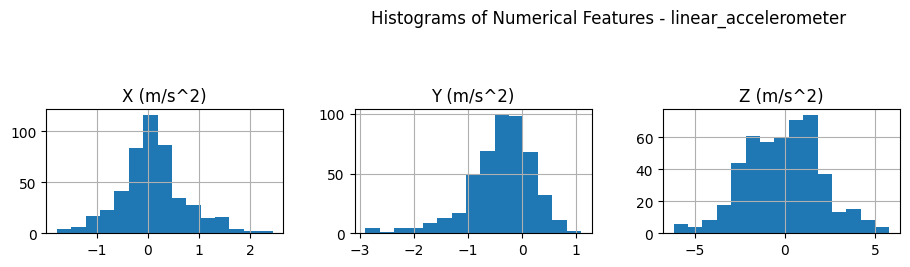

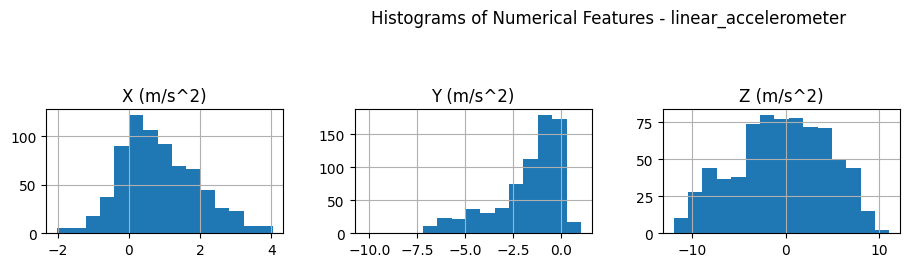

Histograms for magnetometer:


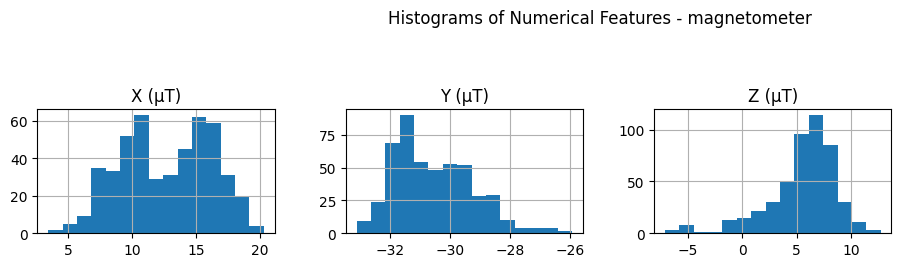

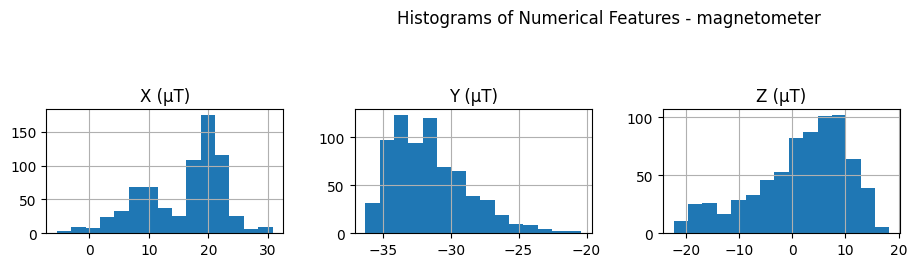

In [11]:
for sensor_type in sensor_types:
    print(f"Histograms for {sensor_type}:")
    for df in aggregated_data_dict[sensor_type]:
        numerical_cols = [col for col in df.columns if col not in ['time', 'label']]
        df[numerical_cols].hist(bins=15, figsize=(15, 10), layout=(5, 4))
        plt.suptitle(f'Histograms of Numerical Features - {sensor_type}')
        plt.show()

Time Series Plots for accelerometer:


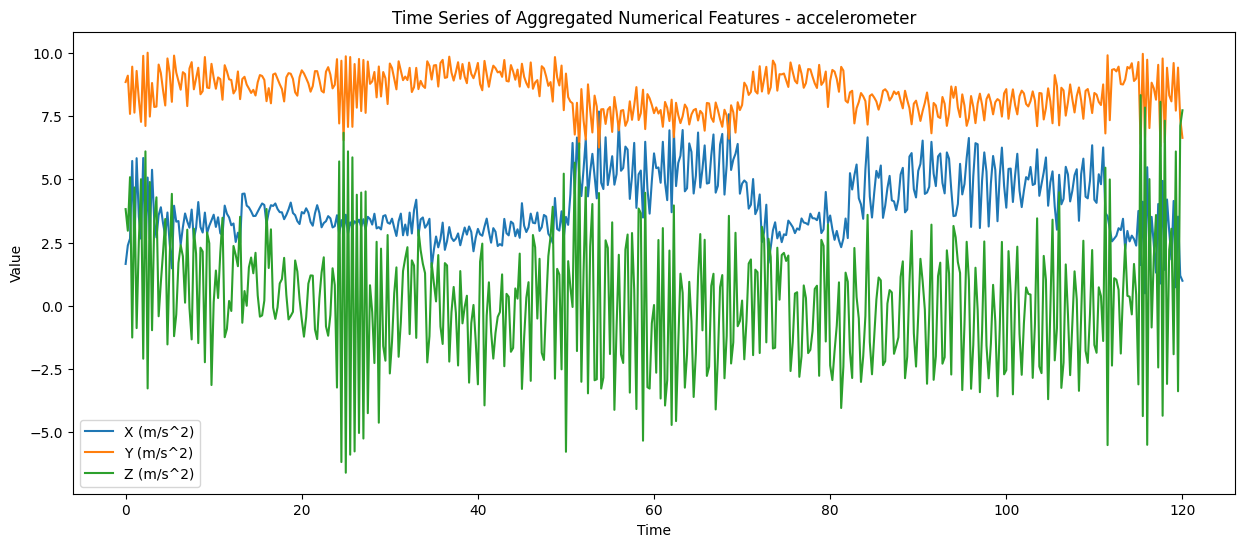

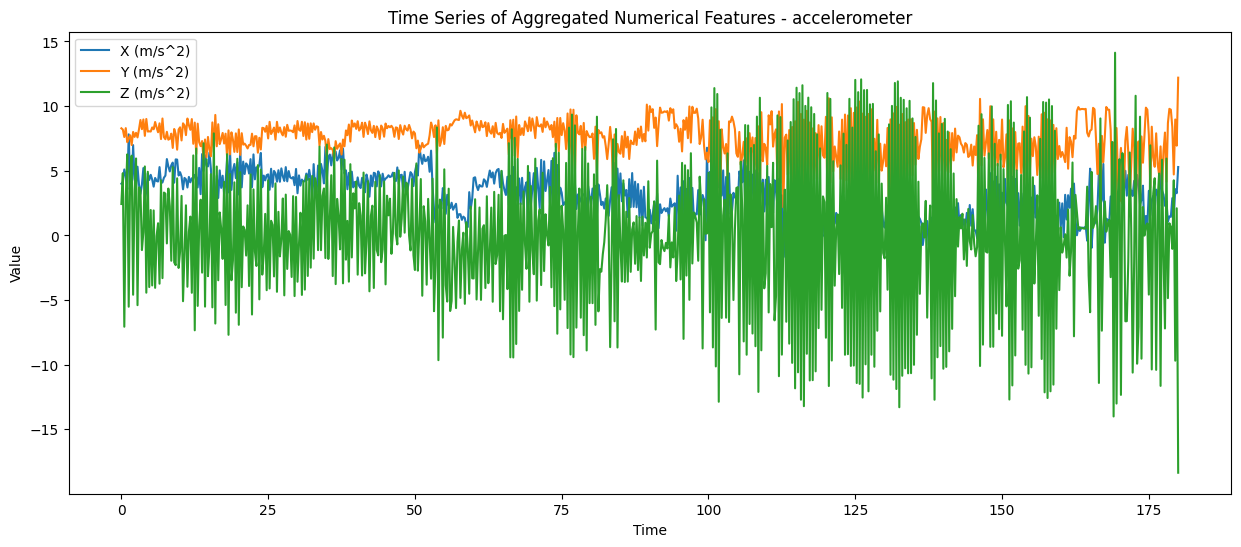

Time Series Plots for gyroscope:


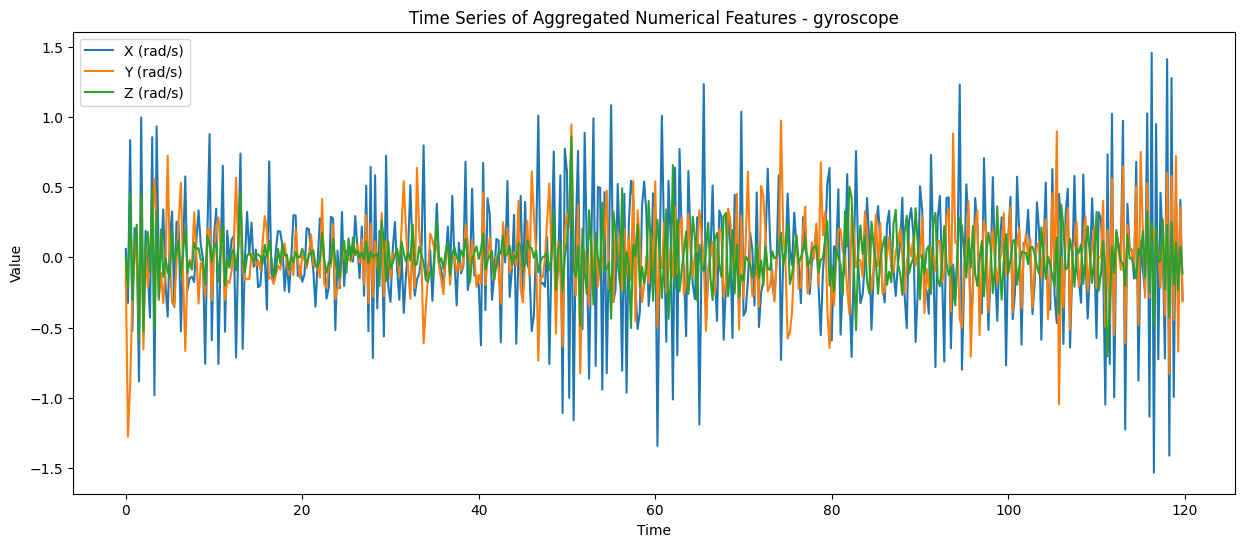

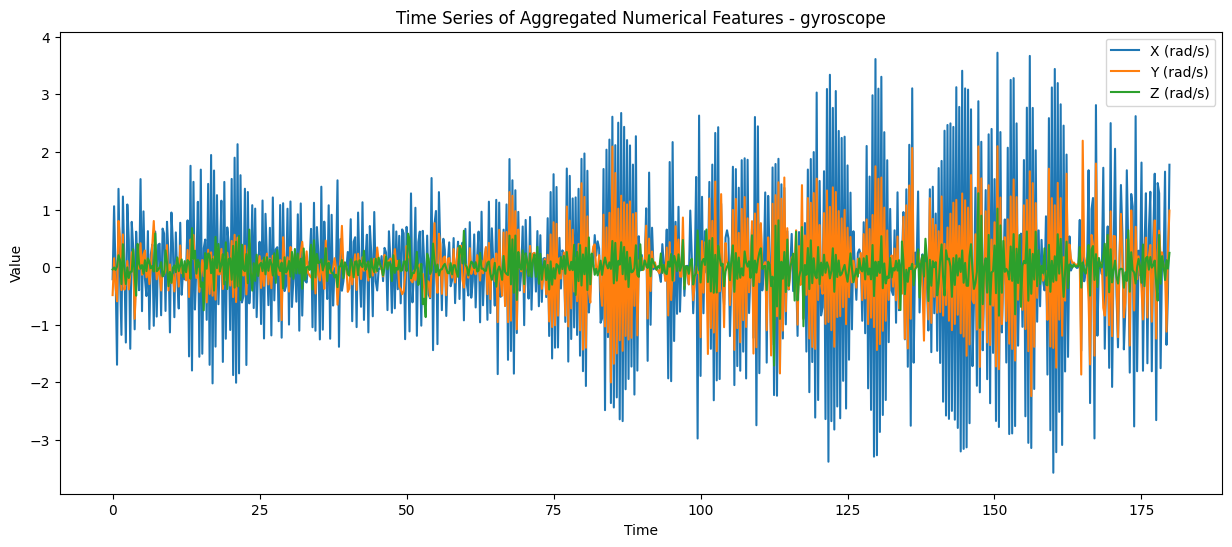

Time Series Plots for linear_accelerometer:


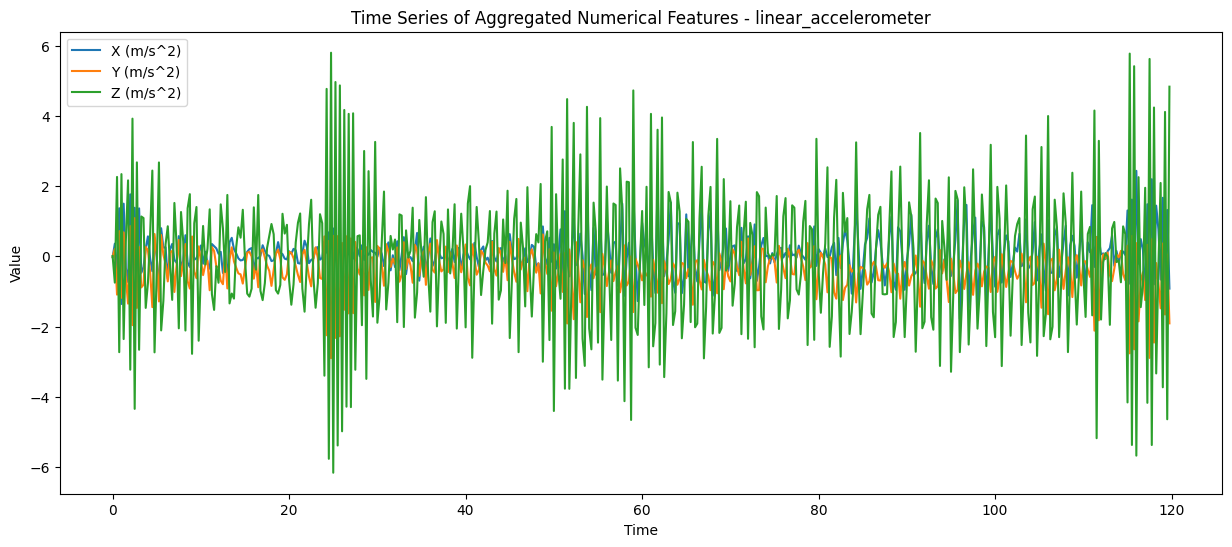

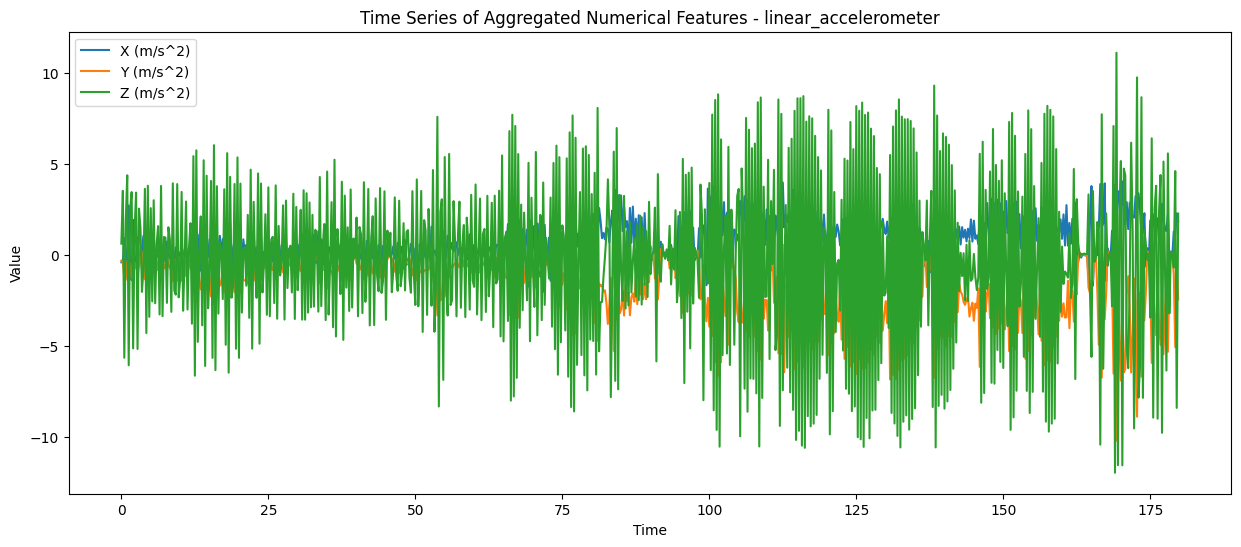

Time Series Plots for magnetometer:


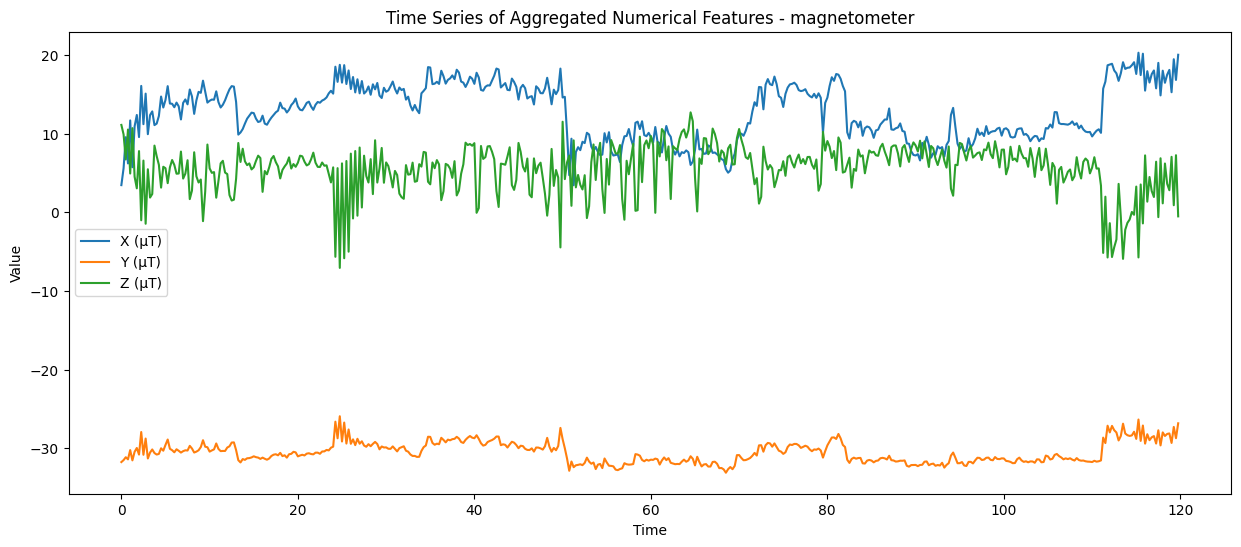

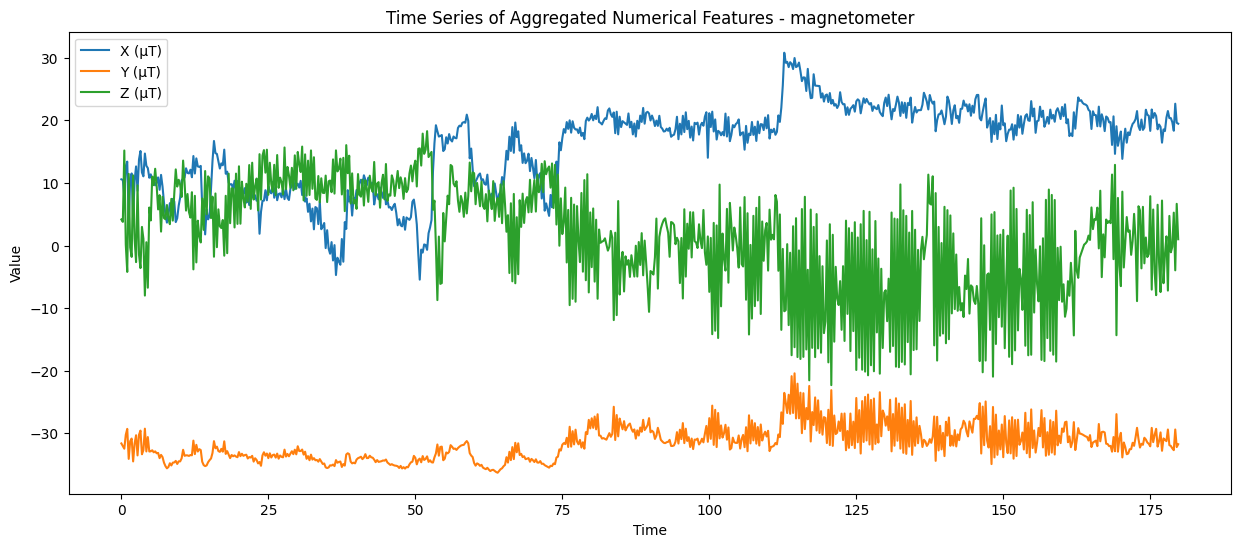

In [12]:
# Plot time series data for the aggregated numerical features
for sensor_type in sensor_types:
    print(f"Time Series Plots for {sensor_type}:")
    for df in aggregated_data_dict[sensor_type]:
        numerical_cols = [col for col in df.columns if col not in ['time', 'label']]
        
        plt.figure(figsize=(15, 6))
        for col in numerical_cols:
            plt.plot(df['time'], df[col], label=col)
        plt.xlabel('Time')
        plt.ylabel('Value')
        plt.title(f'Time Series of Aggregated Numerical Features - {sensor_type}')
        plt.legend()
        plt.show()


# Outlier Checks - simple version

In [13]:
from scipy import stats

# Function to detect outliers using Z-score method
def detect_outliers_zscore(df, threshold=3):
    outliers = pd.DataFrame()
    for col in df.columns:
        if col not in ['time', 'label']:
            z_scores = np.abs(stats.zscore(df[col]))
            outliers[col] = z_scores > threshold
    return outliers

# Detect outliers for each individual file using Z-score method
for sensor_type in sensor_types:
    for i, df in enumerate(aggregated_data_dict[sensor_type]):
        outliers = detect_outliers_zscore(df)
        print(f"Outliers detected in {sensor_type} - File {i+1}:")
        print(outliers.sum())

Outliers detected in accelerometer - File 1:
X (m/s^2)    0
Y (m/s^2)    0
Z (m/s^2)    2
dtype: int64
Outliers detected in accelerometer - File 2:
X (m/s^2)    1
Y (m/s^2)    4
Z (m/s^2)    1
dtype: int64
Outliers detected in gyroscope - File 1:
X (rad/s)    4
Y (rad/s)    7
Z (rad/s)    4
dtype: int64
Outliers detected in gyroscope - File 2:
X (rad/s)    0
Y (rad/s)    1
Z (rad/s)    8
dtype: int64
Outliers detected in linear_accelerometer - File 1:
X (m/s^2)    4
Y (m/s^2)    8
Z (m/s^2)    0
dtype: int64
Outliers detected in linear_accelerometer - File 2:
X (m/s^2)    0
Y (m/s^2)    2
Z (m/s^2)    0
dtype: int64
Outliers detected in magnetometer - File 1:
X (µT)     0
Y (µT)     3
Z (µT)    11
dtype: int64
Outliers detected in magnetometer - File 2:
X (µT)    2
Y (µT)    5
Z (µT)    0
dtype: int64


In [14]:
# Function to detect outliers using IQR method
def detect_outliers_iqr(df, k=1.5):
    outliers = pd.DataFrame()
    for col in df.columns:
        if col not in ['time', 'label']:
            Q1 = df[col].quantile(0.25)
            Q3 = df[col].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - k * IQR
            upper_bound = Q3 + k * IQR
            outliers[col] = (df[col] < lower_bound) | (df[col] > upper_bound)
    return outliers

# Detect outliers for each individual file using IQR method
for sensor_type in sensor_types:
    for i, df in enumerate(aggregated_data_dict[sensor_type]):
        outliers = detect_outliers_iqr(df)
        print(f"Outliers detected in {sensor_type} - File {i+1}:")
        print(outliers.sum())


Outliers detected in accelerometer - File 1:
X (m/s^2)    2
Y (m/s^2)    0
Z (m/s^2)    4
dtype: int64
Outliers detected in accelerometer - File 2:
X (m/s^2)     0
Y (m/s^2)    42
Z (m/s^2)     1
dtype: int64
Outliers detected in gyroscope - File 1:
X (rad/s)    13
Y (rad/s)    17
Z (rad/s)    24
dtype: int64
Outliers detected in gyroscope - File 2:
X (rad/s)     0
Y (rad/s)    29
Z (rad/s)    30
dtype: int64
Outliers detected in linear_accelerometer - File 1:
X (m/s^2)    33
Y (m/s^2)    17
Z (m/s^2)     0
dtype: int64
Outliers detected in linear_accelerometer - File 2:
X (m/s^2)     4
Y (m/s^2)    38
Z (m/s^2)     0
dtype: int64
Outliers detected in magnetometer - File 1:
X (µT)     0
Y (µT)     4
Z (µT)    24
dtype: int64
Outliers detected in magnetometer - File 2:
X (µT)     0
Y (µT)    11
Z (µT)     2
dtype: int64


# Imputation techniques